In [1]:
%load_ext autoreload
%autoreload 2
# %matplotlib widget
%pdb off

from pyCascade import probePost, physics, utils, probeReadWrite
from pyCascade.probeReadWrite import read_probes_file_switch
from filloutVentilationStats import *
from matplotlib import pyplot as plt
from matplotlib import cm, colors
import matplotlib.ticker as ticker
import numpy as np
import scipy as sp
import os
from IPython.core.debugger import set_trace
import pandas as pd
import seaborn as sns
from cycler import cycler
import plotly.express as px
import plotly
import plotly.graph_objects as go
from plotly.offline import plot
from plotly.subplots import make_subplots
from IPython.display import display, HTML
import statsmodels.api as sm
import warnings
import random
import cmcrameri.cm as cmc

plotly.offline.init_notebook_mode()
display(HTML(
    '<script type="text/javascript" async src="https://cdnjs.cloudflare.com/ajax/libs/mathjax/2.7.1/MathJax.js?config=TeX-MML-AM_SVG"></script>'
))

plt.rcParams['figure.dpi'] = 140
im_scaling = .75
plt.rcParams['figure.figsize'] = [6.4 * im_scaling, 4.8 * im_scaling]

############ Universal ################
scratch_home = os.getenv('SCRATCH') #need to set SCRATCH (even if there is no real SCRATCH) to the location where results are written
scratch_dir = f'{scratch_home}/Cascade/city_block_cfd'
home_dir = !pwd
home_dir = home_dir[0]

display(scratch_dir)
display(home_dir)
plt.close('all')

Automatic pdb calling has been turned OFF


ModuleNotFoundError: No module named 'cmcrameri'

## Runs

In [2]:
multiRun_dir = f"{home_dir}/CHARLES/multiRuns/"
plotFolder = f"{multiRun_dir}"

## Read in results

In [3]:
overWrite = False
if os.path.exists(f"{multiRun_dir}/roomVentilationMI.csv") == False or os.path.exists(f"{multiRun_dir}/flowStatsMI.csv") == False or overWrite:

    runs = {
        253: {'A': 45, 'WS': 2, 'C': 2, 'starts': [40000, 120000, 160000], 'stops': [120000, 160000, 240000], 'delT': [0, 5, 5], 'SS': [True, False, True]},
        254: {'A': 45, 'WS': 4, 'C': 2, 'starts': [40000, 120000, 160000], 'stops': [120000, 160000, 240000], 'delT': [0, 5, 5], 'SS': [True, False, True]},
        255: {'A': 0,  'WS': 2, 'C': 2, 'starts': [40000, 120000, 160000], 'stops': [120000, 160000, 240000], 'delT': [0, 5, 5], 'SS': [True, False, True]},
        256: {'A': 0,  'WS': 4, 'C': 2, 'starts': [40000, 120000, 160000], 'stops': [120000, 160000, 240000], 'delT': [0, 5, 5], 'SS': [True, False, True]},
        321: {'A': 45, 'WS': 2, 'C': 3, 'starts': [40000, 120000, 160000], 'stops': [120000, 160000, 240000], 'delT': [0, 5, 5], 'SS': [True, False, True]},
        322: {'A': 45, 'WS': 4, 'C': 3, 'starts': [40000, 120000, 160000], 'stops': [120000, 160000, 240000], 'delT': [0, 5, 5], 'SS': [True, False, True]},
        323: {'A': 0,  'WS': 2, 'C': 3, 'starts': [40000, 120000, 160000], 'stops': [120000, 160000, 240000], 'delT': [0, 5, 5], 'SS': [True, False, True]},
        324: {'A': 0,  'WS': 4, 'C': 3, 'starts': [40000, 120000, 160000], 'stops': [120000, 160000, 240000], 'delT': [0, 5, 5], 'SS': [True, False, True]},
    }

    flowStatsMI, roomVentilationMI = readRunStats(runs, home_dir, scratch_dir, multiRun_dir = plotFolder)
else:
    flowStatsMI = pd.read_csv(f"{multiRun_dir}/flowStatsMI.csv", index_col = [0,1])
    roomVentilationMI = pd.read_csv(f"{multiRun_dir}/roomVentilationMI.csv", index_col = [0,1])

In [4]:
plotdf = roomVentilationMI[roomVentilationMI["houseType"] != "sl"]
plotdf = plotdf[plotdf["SS"] == True]

In [5]:
def IQR(dist):
    # dist = pd.Series(dist)
    # percentiles = dist.describe(percentiles=[0.25, 0.75])
    # return percentiles["75%"] - percentiles["25%"]
    return np.percentile(dist, 75) - np.percentile(dist, 25)
def fullRange(dist):
    return (dist.min(), dist.max())

(0.0, 0.017)

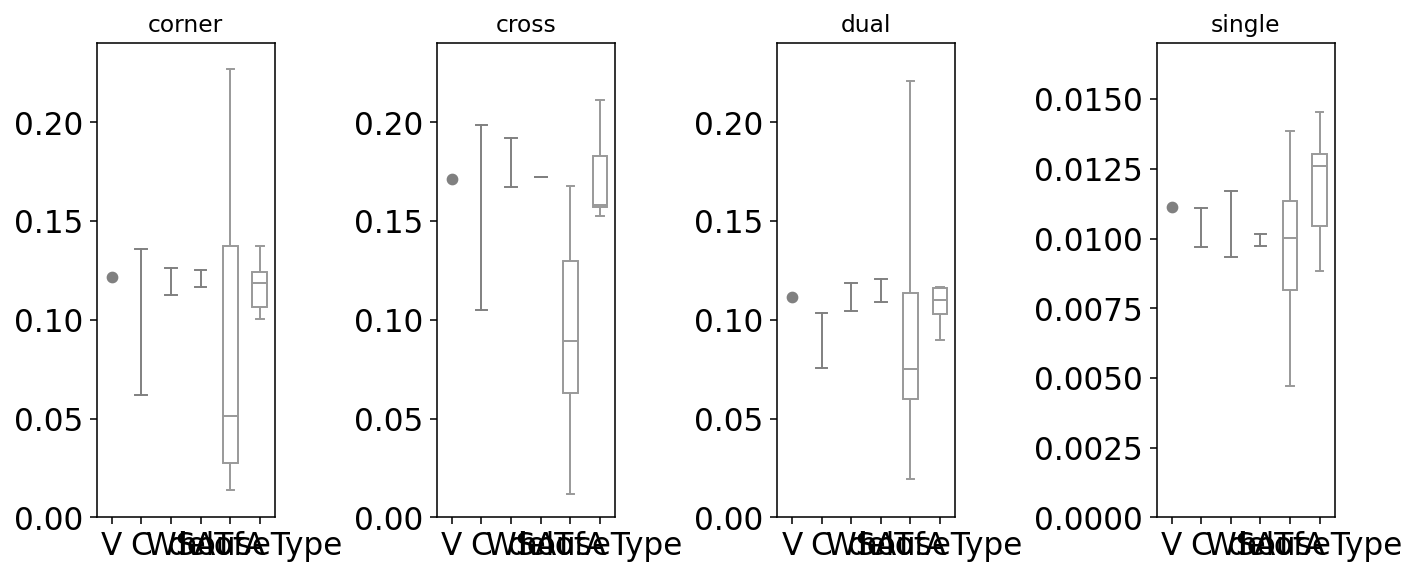

In [26]:
qoi = "mean-sn_prod(abs(u))-Norm"
fig, axes = plt.subplots(1, 4, figsize=(10, 4), layout="constrained")#, sharey = True)
axes = axes.flatten()

roomTypes = plotdf["roomType"].unique()
params = ["C", "AofA", "houseType", "WS", "delT"]
for i, roomType in enumerate(roomTypes):
    roomSpread = IQR(plotdf[plotdf["roomType"] == roomType][qoi])
    sns.pointplot(ax=axes[i], x=["V"], y=roomSpread, color='gray', markersize=4)
    spreads = pd.DataFrame(index = ["param", "value"])
    for p in params:
        values = plotdf[p].unique()
        for v in values:
            df = plotdf[(plotdf[p] == v) & (plotdf["roomType"] == roomType)][qoi]
            # roomSpread = IQR(plotdf[plotdf["roomType"] == roomType][qoi])
            # df /= roomSpread

            spreads[f"{p}-{v}"] = [p, IQR(df)]
    spreads = spreads.T
    sns.pointplot(ax=axes[i], data = spreads[(spreads["param"]=="C") | (spreads["param"]=="WS") | (spreads["param"]=="delT")], x="param", y="value", color="gray", errorbar=fullRange, capsize=.4, markersize=0, linestyles='None', linewidth=1)    
    sns.boxplot(ax=axes[i], data = spreads[(spreads["param"]=="AofA") | (spreads["param"]=="houseType")], x="param", y="value", color="1", linewidth=1, fliersize=1, width =.5, whis=(0, 100))

    axes[i].set_ylabel(None)
    axes[i].set_xlabel(None)
    axes[i].set_ylim([0, .24])
    axes[i].set_title(roomType)
    axes[i].tick_params(axis='both', which='major', labelsize=16)

axes[-1].set_ylim([0, .017])

(0.0, 0.0125)

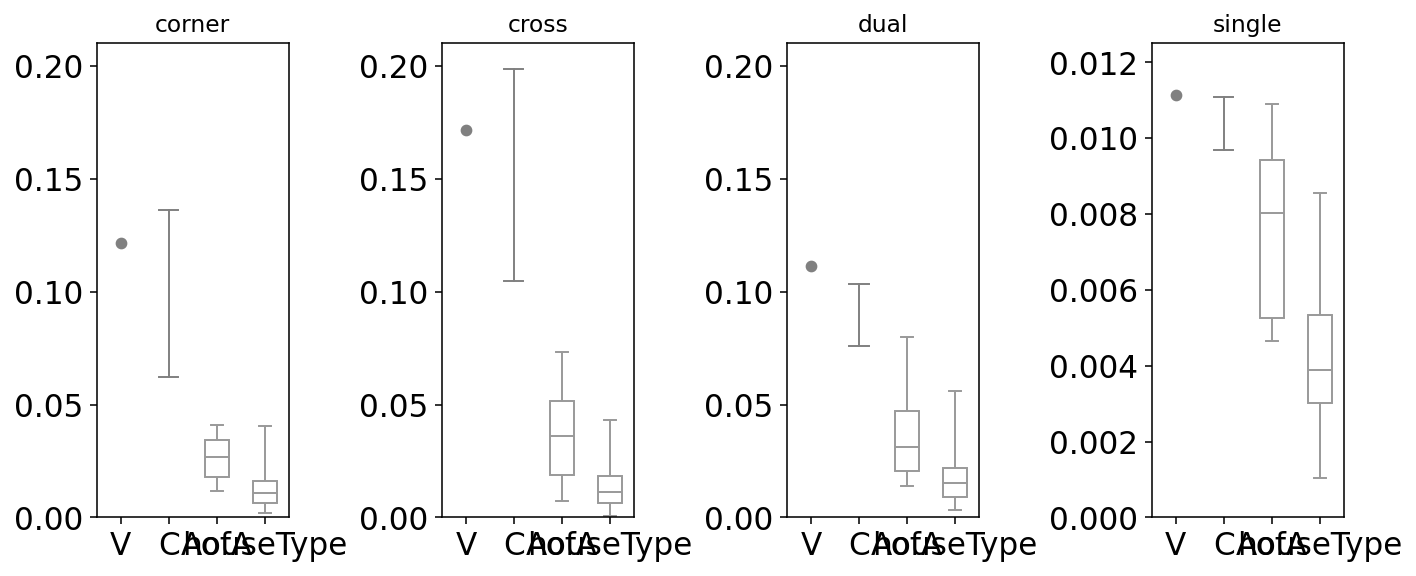

In [27]:
def recursive_spreads(df, params, spreads, pair = [0,0]):
    if len(params) == 0:
        r = random.randrange(100000)
        spreads[f"{pair[0]}-{pair[1]}-{r}"] = [pair[0], IQR(df[qoi])]
        return
    p = params[0]
    values = df[p].unique()
    for v in values:
        recursive_spreads(df[df[p] == v].copy(), params[1:].copy(), spreads, pair=[p, v])
        
qoi = "mean-sn_prod(abs(u))-Norm"
fig, axes = plt.subplots(1, 4, figsize=(10, 4), layout="constrained")#, sharey = True)
axes = axes.flatten()

roomTypes = plotdf["roomType"].unique()
params = ["C", "AofA", "houseType"]
for i, roomType in enumerate(roomTypes):
    roomSpread = IQR(plotdf[plotdf["roomType"] == roomType][qoi])
    sns.pointplot(ax=axes[i], x=["V"], y=roomSpread, color='gray', markersize=4)
    spreads = pd.DataFrame(index = ["param", "value"])
    for j in range(len(params)):
        df = plotdf[plotdf["roomType"] == roomType]
        recursive_spreads(df, params[0:j+1], spreads)

    spreads = spreads.T
    sns.pointplot(ax=axes[i], data = spreads[spreads["param"]=="C"], x="param", y="value", color="gray", errorbar=fullRange, capsize=.4, markersize=0, linestyles='None', linewidth=1)    
    sns.boxplot(ax=axes[i], data = spreads[spreads["param"]!="C"], x="param", y="value", color="1", linewidth=1, fliersize=1, width =.5, whis=(0,100))


    axes[i].set_ylabel(None)
    axes[i].set_xlabel(None)
    axes[i].set_ylim([0, .21])
    axes[i].set_title(roomType)
    axes[i].tick_params(axis='both', which='major', labelsize=16)

axes[-1].set_ylim([0, .0125])

/home/groups/gorle/codes/miniconda3/envs/pycascade/lib/python3.10/site-packages/seaborn/categorical.py:3370: UserWarning:

37.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.

/home/groups/gorle/codes/miniconda3/envs/pycascade/lib/python3.10/site-packages/seaborn/categorical.py:3370: UserWarning:

65.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.

/home/groups/gorle/codes/miniconda3/envs/pycascade/lib/python3.10/site-packages/seaborn/categorical.py:3370: UserWarning:

47.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.

/home/groups/gorle/codes/miniconda3/envs/pycascade/lib/python3.10/site-packages/seaborn/categorical.py:3370: UserWarning:

66.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.

/home/groups/gorle/codes/miniconda3/envs/pycascade/lib/python3.10/site-packages/seab

(0.0, 0.0125)

/home/groups/gorle/codes/miniconda3/envs/pycascade/lib/python3.10/site-packages/seaborn/categorical.py:3370: UserWarning:

6.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.

/home/groups/gorle/codes/miniconda3/envs/pycascade/lib/python3.10/site-packages/seaborn/categorical.py:3370: UserWarning:

73.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.

/home/groups/gorle/codes/miniconda3/envs/pycascade/lib/python3.10/site-packages/seaborn/categorical.py:3370: UserWarning:

60.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.

/home/groups/gorle/codes/miniconda3/envs/pycascade/lib/python3.10/site-packages/seaborn/categorical.py:3370: UserWarning:

62.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.

/home/groups/gorle/codes/miniconda3/envs/pycascade/lib/python3.10/site-packages/seabo

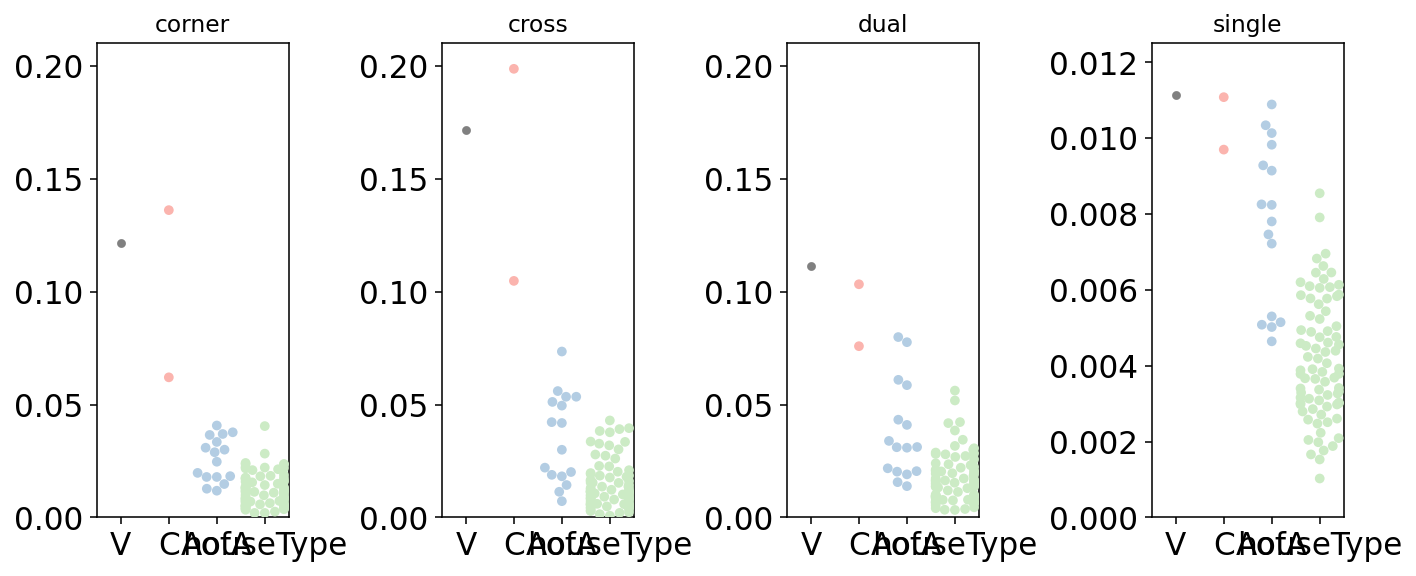

In [54]:
qoi = "mean-sn_prod(abs(u))-Norm"
fig, axes = plt.subplots(1, 4, figsize=(10, 4), layout="constrained")#, sharey = True)
axes = axes.flatten()

roomTypes = plotdf["roomType"].unique()
params = ["C", "AofA", "houseType"]
for i, roomType in enumerate(roomTypes):
    roomSpread = IQR(plotdf[plotdf["roomType"] == roomType][qoi])
    sns.pointplot(ax=axes[i], x=["V"], y=roomSpread, color='grey', markersize=2.5)
    spreads = pd.DataFrame(index = ["param", "value"])
    for j in range(len(params)):
        df = plotdf[plotdf["roomType"] == roomType]
        recursive_spreads(df, params[0:j+1], spreads)

    spreads = spreads.T
    sns.swarmplot(ax=axes[i], data = spreads, x="param", y="value", color="gray",  size=5, hue="param", palette = 'Pastel1')    


    axes[i].set_ylabel(None)
    axes[i].set_xlabel(None)
    axes[i].set_ylim([0, .21])
    axes[i].set_title(roomType)
    axes[i].tick_params(axis='both', which='major', labelsize=16)

axes[-1].set_ylim([0, .0125])